In [190]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(1)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OrdinalEncoder #We use the ordinal encoder for the labels as there are only two values and it will work for what we need. 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,auc
import statistics as stats
import warnings
warnings.filterwarnings("ignore")
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, History, LearningRateScheduler
from tensorflow.keras import regularizers
# from tensorflow.keras.layers import Recurrent_Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers 
import time
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Importing the data

In [3]:
df=pd.read_csv('diabetes_data.csv')


## Data exploration

Exploring our data and checking for missing values and outliers

In [6]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


### Checking for missing values

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

We can see that there are no null values. 

In [7]:
# Looking at the age distribution
df.describe()

,Age
count,520.000000
mean,48.028846
std,12.151466
min,16.000000
25%,39.000000
50%,47.500000
75%,57.000000
max,90.000000


### Checking for outliers

In [8]:
df.Age.value_counts()

35    30
48    28
43    25
30    25
40    24
55    22
47    21
53    20
38    20
50    18
45    18
58    18
54    16
39    16
60    15
57    15
68    10
42     9
72     9
28     9
66     9
61     8
67     8
56     8
46     8
36     8
49     7
44     7
37     7
62     7
27     6
65     6
34     6
32     5
64     5
70     5
69     5
51     5
33     4
41     4
52     4
59     4
31     3
63     3
85     2
90     2
25     2
29     1
79     1
26     1
16     1
Name: Age, dtype: int64

In [9]:
attr_categorical = ["Gender","Polyuria","Polydipsia", "sudden weight loss","weakness","Polyphagia","Genital thrush",
                    "visual blurring","Itching","Irritability","delayed healing","partial paresis","muscle stiffness","Alopecia","Obesity","class"]
attr_num  = ["Age"]

In [10]:
### Data distribution

In [11]:
for label in attr_categorical:
    
    print(df[label].value_counts(normalize=True))

Male      0.630769
Female    0.369231
Name: Gender, dtype: float64
No     0.503846
Yes    0.496154
Name: Polyuria, dtype: float64
No     0.551923
Yes    0.448077
Name: Polydipsia, dtype: float64
No     0.582692
Yes    0.417308
Name: sudden weight loss, dtype: float64
Yes    0.586538
No     0.413462
Name: weakness, dtype: float64
No     0.544231
Yes    0.455769
Name: Polyphagia, dtype: float64
No     0.776923
Yes    0.223077
Name: Genital thrush, dtype: float64
No     0.551923
Yes    0.448077
Name: visual blurring, dtype: float64
No     0.513462
Yes    0.486538
Name: Itching, dtype: float64
No     0.757692
Yes    0.242308
Name: Irritability, dtype: float64
No     0.540385
Yes    0.459615
Name: delayed healing, dtype: float64
No     0.569231
Yes    0.430769
Name: partial paresis, dtype: float64
No     0.625
Yes    0.375
Name: muscle stiffness, dtype: float64
No     0.655769
Yes    0.344231
Name: Alopecia, dtype: float64
No     0.830769
Yes    0.169231
Name: Obesity, dtype: float64
Positi

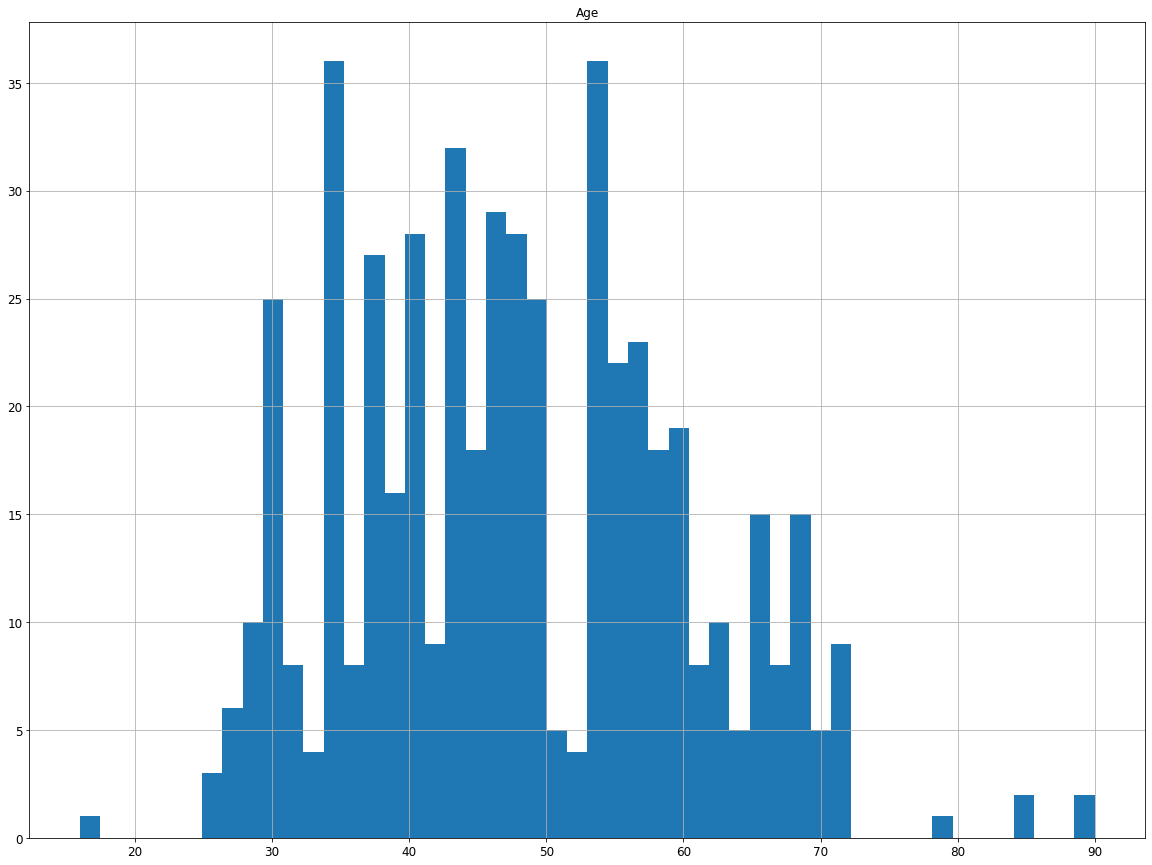

In [12]:

import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

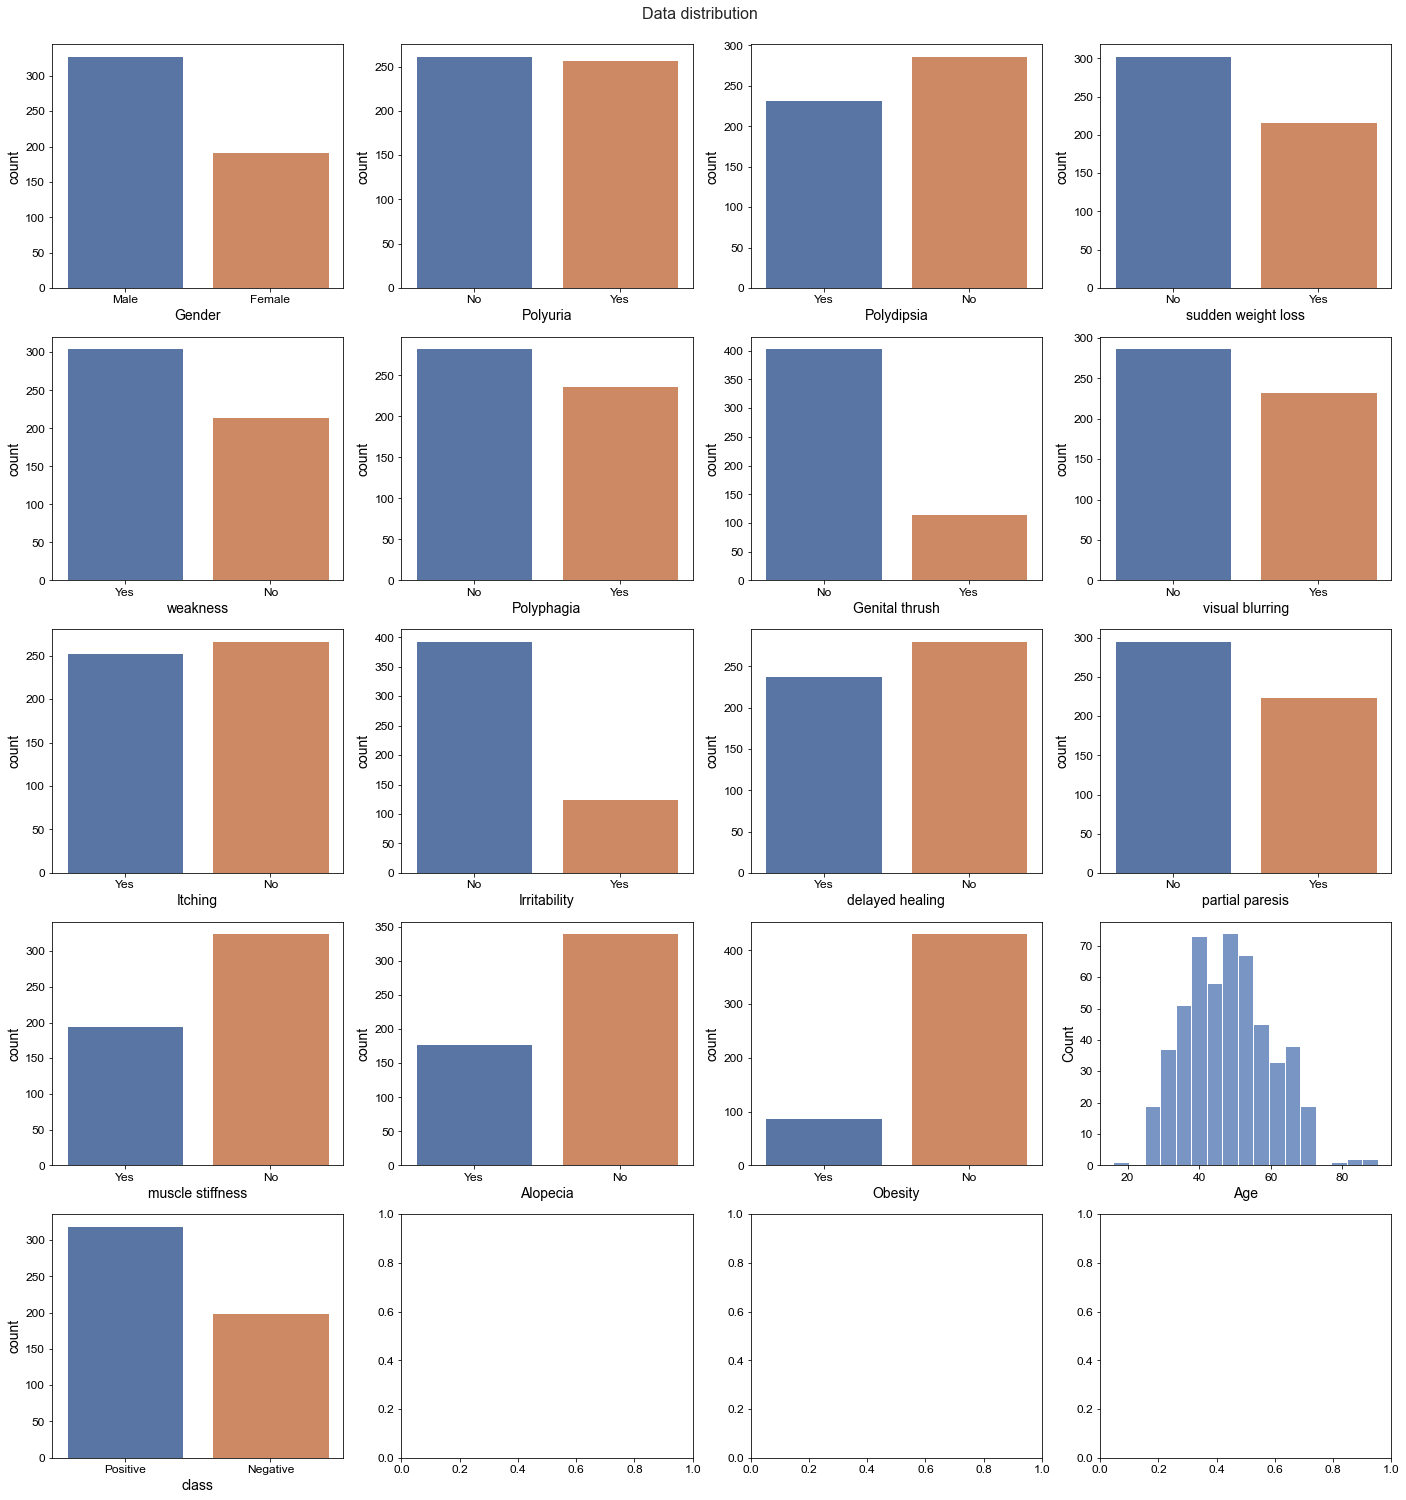

In [13]:


fig, ax =plt.subplots(5,4, figsize=(24
                                    , 26))
   
sns.set( {'axes.labelsize' : 16 })
sns.countplot(ax = ax[0,0], x = df['Gender'])

sns.countplot(ax = ax[0,1], x = df['Polyuria'])

sns.countplot(ax = ax[0,2], x = df['Polydipsia'])

sns.countplot(ax = ax[0,3], x = df['sudden weight loss'])

sns.countplot(ax = ax[1,0], x = df['weakness'])

sns.countplot(ax = ax[1,1], x = df['Polyphagia'])

sns.countplot(ax = ax[1,2], x = df['Genital thrush'])

sns.countplot(ax = ax[1,3], x = df['visual blurring'])

sns.countplot(ax = ax[2,0], x = df['Itching'])

sns.countplot(ax = ax[2,1], x = df['Irritability'])

sns.countplot(ax = ax[2,2], x = df['delayed healing'])

sns.countplot(ax = ax[2,3], x = df['partial paresis'])

sns.countplot(ax = ax[3,0], x = df['muscle stiffness'])

sns.countplot(ax = ax[3,1], x = df['Alopecia'])

sns.countplot(ax = ax[3,2], x = df['Obesity'])
sns.histplot(ax=ax[3,3], x=df['Age'])
sns.countplot(ax = ax[4,0], x = df['class'])

fig.suptitle('Data distribution', y =0.9, size = 16)  

plt.savefig('data_vis.png')

### Checking for imbalanced data

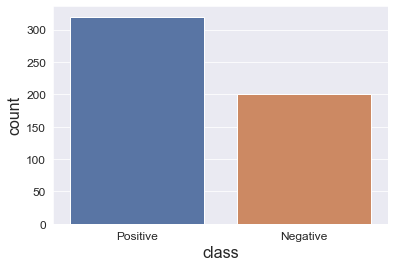

In [14]:
ax = sns.countplot(x = df["class"])  
plt.show()

We can see that the minority class os approximately 38% of the data, so we have a mildly imbalanced dataset. 
https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

## Data preparation

### Handling Categorical data

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OrdinalEncoder #We use the ordinal encoder for the labels as there are only two values and it will work for what we need. 
ordinal_encoder = OrdinalEncoder()
num_pipeline = Pipeline([('std_scaler', StandardScaler()) # Scaling numerical values
 ])




full_pipeline = ColumnTransformer([
        ("num", num_pipeline, attr_num), #Scaling the data with Standard scalar
        ("cat", ordinal_encoder, attr_categorical), # Transforming categorical data  
    ])

data_prepared = full_pipeline.fit_transform(df)

data = pd.DataFrame(data_prepared, columns = df.columns)

## Looking for colinearity and correlations 

In [16]:
corr_matrix = data.corr(method = "pearson")

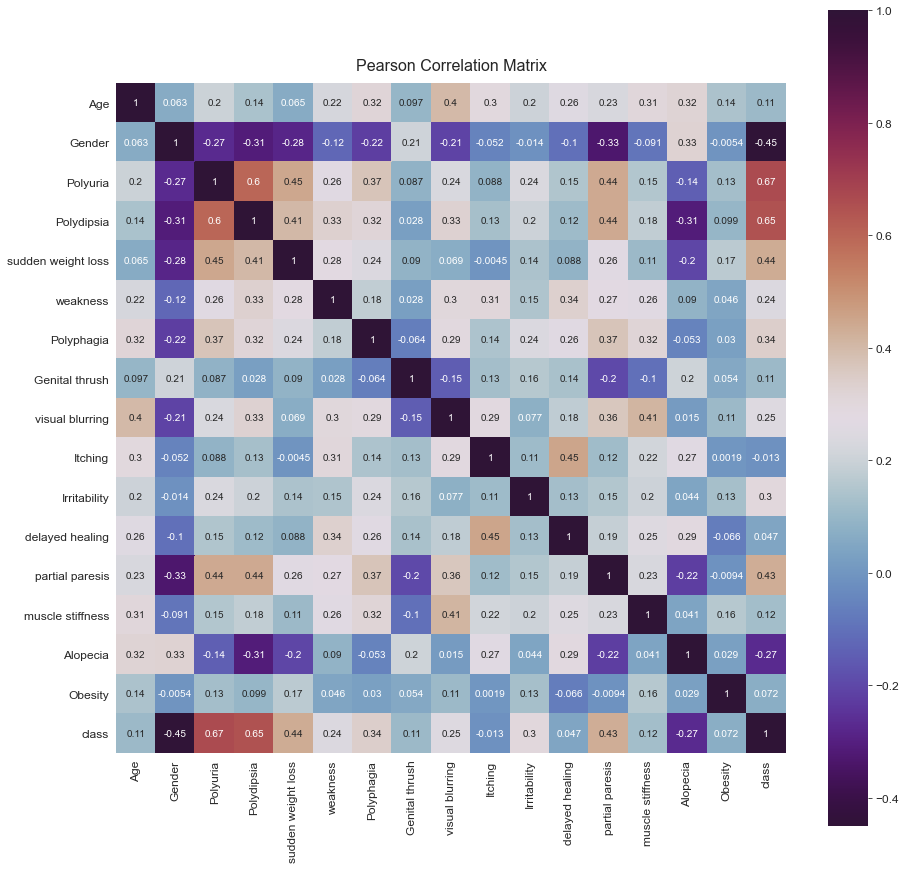

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix,square=True,annot=True,cmap= 'twilight_shifted')

plt.title('Pearson Correlation Matrix', y =1.01, size = 16)  

plt.savefig('Pearson correlation.png')

In [18]:
corr_matrix = data.corr(method = "spearman")

<AxesSubplot:title={'center':'Spearman Correlation Matrix'}>

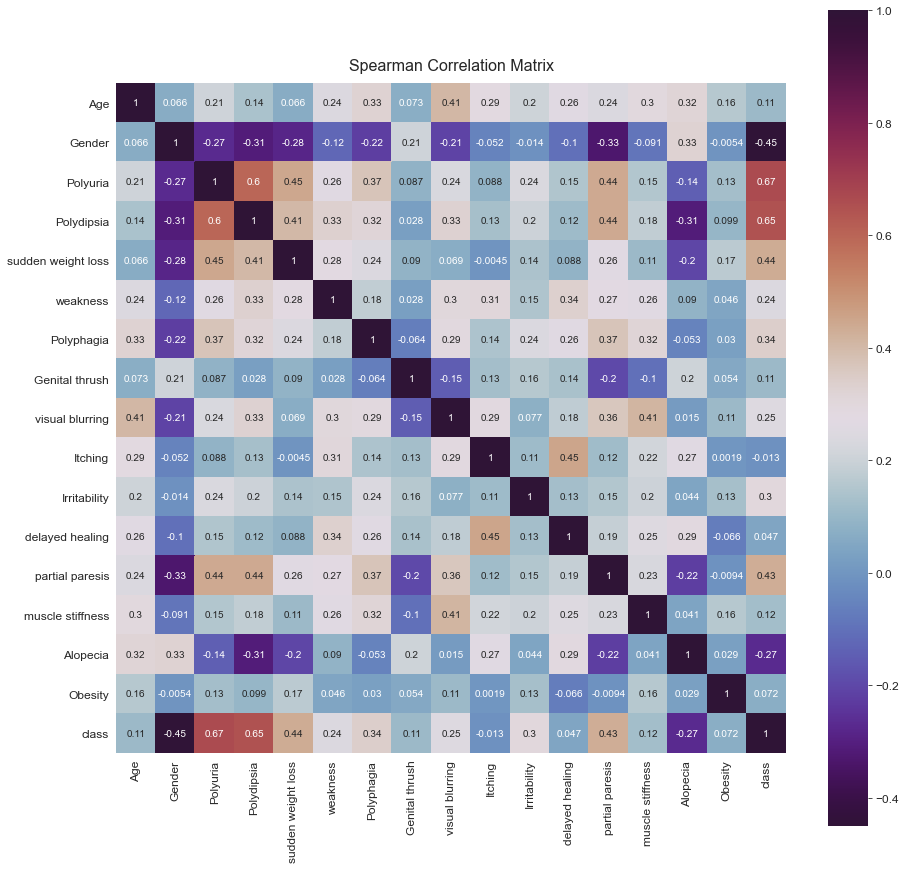

In [19]:
plt.figure(figsize=(15,15))
plt.title('Spearman Correlation Matrix', y =1.01, size = 16) 
sns.heatmap(corr_matrix,square=True,annot=True,cmap= 'twilight_shifted')

There is a moderetely increased correlation between polyuria and polydipsia which makes sense as increased thirst would lead to increased urination. Overall there are no stong correlations in our dataset. 

## Preparing the data for Machine learning algorithms
### Splitting the data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
data_labels = data['class']
data_p = data.drop('class', axis = 1)

In [22]:
df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8)

In [23]:
df_train.shape, train_labels.shape, df_test.shape, test_labels.shape

((416, 16), (416,), (104, 16), (104,))

In [24]:
##### Loading the Machne learning models

In [25]:
forest = RandomForestClassifier()

knn = KNeighborsClassifier()
XGB = XGBClassifier()
voting_clf = VotingClassifier(
 estimators=[('forest', forest), ('knn', knn), ('xgb', XGB)],
 voting='soft'
 )

In [27]:
smote= SMOTE()
df_train,train_labels = smote.fit_resample(df_train,train_labels)
df_train.shape, train_labels.shape, df_test.shape, test_labels.shape

((508, 16), (508,), (104, 16), (104,))

In [28]:
classifiers = [forest,knn,XGB,voting_clf]
from sklearn.metrics import plot_confusion_matrix

### Classification report and confusion matrices

We run all classifiers once to estimate their performance

In [34]:
for clf in classifiers:
    clf.fit(df_train,train_labels)
    y_pred = clf.predict(df_test)
    f_probs = clf.predict_proba(df_test)[:, 1]
    clf_auc = roc_auc_score(test_labels,f_probs)
    print('Train accuracy: {}'.format(clf.score(df_train, train_labels)))
    print('Test accuracy: {}'.format(clf.score(df_test, test_labels)))
    print('AUC score: ',(clf_auc))
    print('For Classifier',clf,classification_report(test_labels, y_pred,digits=3))



Train accuracy: 1.0
Test accuracy: 0.9807692307692307
AUC score:  0.9972089314194577
For Classifier RandomForestClassifier()               precision    recall  f1-score   support

         0.0      1.000     0.947     0.973        38
         1.0      0.971     1.000     0.985        66

    accuracy                          0.981       104
   macro avg      0.985     0.974     0.979       104
weighted avg      0.981     0.981     0.981       104

Train accuracy: 0.9586614173228346
Test accuracy: 0.8942307692307693
AUC score:  0.9621212121212122
For Classifier KNeighborsClassifier()               precision    recall  f1-score   support

         0.0      0.800     0.947     0.867        38
         1.0      0.966     0.864     0.912        66

    accuracy                          0.894       104
   macro avg      0.883     0.906     0.890       104
weighted avg      0.905     0.894     0.896       104

[22:57:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

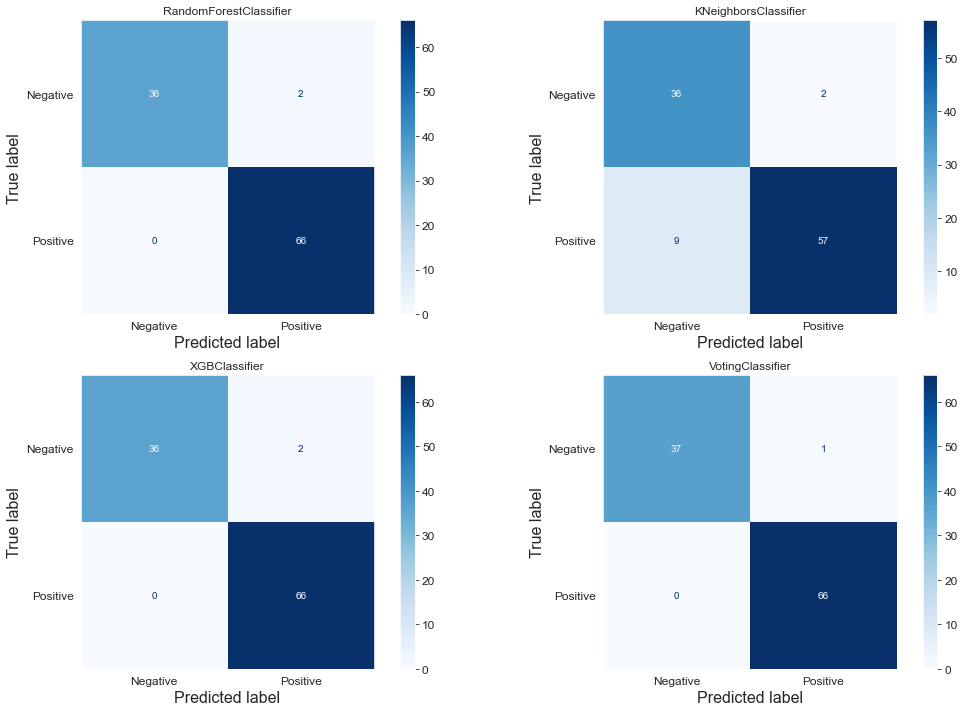

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          df_test, 
                          test_labels, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=['Negative','Positive'])
    ax.title.set_text(type(cls).__name__)
    ax.grid(False)
    plt.grid(False)

plt.tight_layout()

#plt.show()

plt.savefig('conf_matrix.png')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               8704      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262144    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 271,361
Trainable params: 271,361
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1500
16/16 [==============================] - 1s 5ms/step - loss: 4.9625 - auc_1: 0.9091 - accuracy: 0.7972
Epoch 2/1500
16/16 [==============================] - 0s 5ms/step - loss: 3.2036 - auc_1: 0.9718 - accuracy: 0.9370
Epoch 3/1

16/16 [==============================] - 0s 5ms/step - loss: 0.1099 - auc_1: 0.9997 - accuracy: 0.9902
Epoch 133/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1106 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 134/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1137 - auc_1: 0.9996 - accuracy: 0.9843
Epoch 135/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1080 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 136/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.1087 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 137/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1106 - auc_1: 0.9996 - accuracy: 0.9902
Epoch 138/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.1095 - auc_1: 0.9997 - accuracy: 0.9882
Epoch 139/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1102 - auc_1: 0.9997 - accuracy: 0.9882
Epoch 140/1500
16/16 [==============================] - 0s 4ms/step - l

16/16 [==============================] - 0s 4ms/step - loss: 0.0747 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 271/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0722 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 272/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0716 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 273/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0705 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 274/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0717 - auc_1: 0.9999 - accuracy: 0.9902
Epoch 275/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0696 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 276/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0765 - auc_1: 0.9997 - accuracy: 0.9941
Epoch 277/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0722 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 278/1500
16/16 [==============================] - 0s 4ms/step - l

16/16 [==============================] - 0s 4ms/step - loss: 0.0652 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 340/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0669 - auc_1: 0.9998 - accuracy: 0.9902
Epoch 341/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0655 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 342/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0649 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 343/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0632 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 344/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0628 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 345/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0662 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 346/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0713 - auc_1: 0.9997 - accuracy: 0.9921
Epoch 347/1500
16/16 [==============================] - 0s 4ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0566 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 478/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0575 - auc_1: 0.9999 - accuracy: 0.9902
Epoch 479/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0517 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 480/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0527 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 481/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0532 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 482/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0526 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 483/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0528 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 484/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0535 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 485/1500
16/16 [==============================] - 0s 5ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0500 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 616/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0465 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 617/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0473 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 618/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0483 - auc_1: 0.9999 - accuracy: 0.9902
Epoch 619/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0481 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 620/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0478 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 621/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0467 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 622/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0486 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 623/1500
16/16 [==============================] - 0s 5ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0441 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 685/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0461 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 686/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0463 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 687/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0427 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 688/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0451 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 689/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0497 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 690/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0538 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 691/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0494 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 692/1500
16/16 [==============================] - 0s 5ms/step - l

Epoch 822/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0393 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 823/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0430 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 824/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0405 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 825/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0421 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 826/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0409 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 827/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0419 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 828/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0419 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 829/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0416 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 830/1500
16/16 [==============================] - 

16/16 [==============================] - 0s 5ms/step - loss: 0.0404 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 959/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0384 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 960/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0393 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 961/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0406 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 962/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0385 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 963/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0431 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 964/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0390 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 965/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0384 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 966/1500
16/16 [==============================] - 0s 5ms/step - l

Epoch 1095/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0370 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 1096/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0353 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1097/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0353 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1098/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0366 - auc_1: 1.0000 - accuracy: 0.9921
Epoch 1099/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0388 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 1100/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0364 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1101/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0369 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1102/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0360 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1103/1500
16/16 [=========================

16/16 [==============================] - 0s 5ms/step - loss: 0.0343 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1232/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0322 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1233/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0350 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1234/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0377 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1235/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0347 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 1236/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0340 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1237/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0335 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1238/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0335 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1239/1500
16/16 [==============================] - 0s 5ms/

Epoch 1300/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0328 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1301/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0332 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1302/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0351 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 1303/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0334 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1304/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0350 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 1305/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0347 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1306/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0347 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1307/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0340 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1308/1500
16/16 [=========================

16/16 [==============================] - 0s 5ms/step - loss: 0.0323 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1437/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0311 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1438/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0314 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1439/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0319 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1440/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0315 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1441/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0343 - auc_1: 0.9999 - accuracy: 0.9902
Epoch 1442/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0311 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 1443/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0363 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 1444/1500
16/16 [==============================] - 0s 5ms/

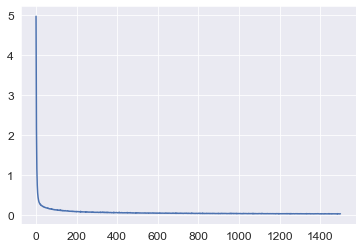

4/4 [==============================] - 0s 2ms/step - loss: 0.0841 - auc_1: 0.9972 - accuracy: 0.9808
Test loss: 0.08405529707670212
Test AUC (from tf): 0.9972089529037476
Test accuracy: 0.9807692170143127
4/4 [==============================] - 0s 2ms/step - loss: 0.0841 - auc_1: 0.9972 - accuracy: 0.9808
[0.08405529707670212, 0.9972089529037476, 0.9807692170143127]


In [37]:
#MLNN first run
np.random.seed(1)
smote= SMOTE()
X_train, X_test, y_train, y_test = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
X_train,y_train = smote.fit_resample(X_train,y_train)
input_dim = 16
num_classes = 1
num_epochs = 1500
layer_dim = 1
learning_rate = 0.001
batch_size =32#int(opt)32
dropout=0.05
hidden_dim=512
output_activation = 'sigmoid'
initial_activation = 'relu'
kernel_initializer="glorot_uniform"
bias_initializer="glorot_uniform"
loss_function=tf.keras.losses.BinaryCrossentropy()
optimiser=optimizers.Adamax(lr=learning_rate)
metric=tf.keras.metrics.AUC()#,tf.keras.metrics.Accuracy()
kernel_regularizer='l2' # ,'l1'

##Building the MLP
        
history = History()
model = Sequential()

#Add input layer
model.add(Dense(hidden_dim, input_dim=input_dim, activation=initial_activation, use_bias=True, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
model.add(Dropout(dropout))
#Add hidden layer
model.add(Dense(hidden_dim, activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
#Add output layer
model.add(Dense(units=num_classes, activation=output_activation))
   
sgd=optimizers.Adamax(lr=learning_rate)     
model.compile(loss=loss_function,
              optimizer=optimiser,
              metrics=[metric,'accuracy']) 
print(model.summary())
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[history])
plt.plot(history.history['loss'], label='train')
plt.show()

#Model Evaluation
score =(loss, AUC,accuracy) = model.evaluate(X_test, y_test, verbose=1)
#y_pred=model.predict(X_test)
#print('Test AUC (from sklearn):',custom_auc(y_test, y_pred))
print('Test loss:',score[0])
print('Test AUC (from tf):',score[1])
print('Test accuracy:',score[2])
print(model.evaluate(X_test, y_test, verbose=1))
#print('Test f1-score:',score[3])
#print('Test precision:',score[4])
#print('Test recall:',score[5])

In [46]:
mnn_pred = model.predict_classes(X_test)

In [47]:
# precision tp / (tp + fp)
precision = precision_score(y_test, mnn_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, mnn_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, mnn_pred)
print('F1 score: %f' % f1)

Precision: 0.984848
Recall: 0.984848
F1 score: 0.984848


In [48]:
cm = confusion_matrix(y_true=y_test, y_pred=mnn_pred.round())

Confusion matrix, without normalization
[[37  1]
 [ 1 65]]


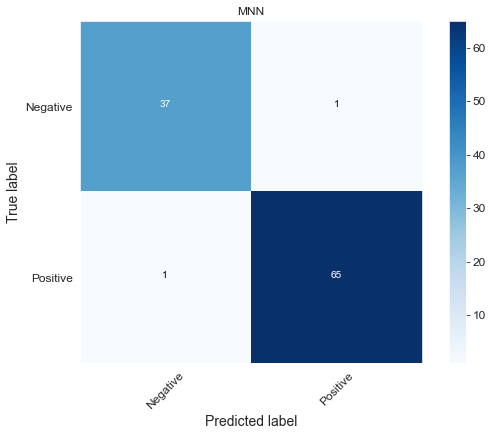

In [49]:
#Confusion map for MLNN
import itertools
from matplotlib.pyplot import figure
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    
   
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gcf().subplots_adjust(bottom=0.15)

    plt.savefig('mnn_conf_matrix.png')
    
plot_confusion_matrix(cm=cm, classes=['Negative','Positive'], title='MNN')

## Feature importance and correlation

In [50]:
importances = forest.feature_importances_

In [51]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.feature_names_in_)
attributes = attr_num + cat_one_hot_attribs
sorted(zip(importances, attributes), reverse=True) # Displays importance scores next to attribute names. 

[(0.2469008367433022, 'Polydipsia'),
 (0.19973727698360583, 'Polyuria'),
 (0.09140465633197202, 'Age'),
 (0.091011750969409, 'Gender'),
 (0.05676086974230413, 'sudden weight loss'),
 (0.05177760155254941, 'partial paresis'),
 (0.041164113853018255, 'Alopecia'),
 (0.03430624203109202, 'Polyphagia'),
 (0.032876508079859104, 'Irritability'),
 (0.028791384112479883, 'Itching'),
 (0.026862312936880052, 'visual blurring'),
 (0.025390337493603553, 'delayed healing'),
 (0.020449435276088092, 'Genital thrush'),
 (0.020044877773120025, 'muscle stiffness'),
 (0.01708937855467797, 'Obesity'),
 (0.015432417566038453, 'weakness')]

In [55]:
attributes

['Age',
 'Gender',
 'Polyuria',
 'Polydipsia',
 'sudden weight loss',
 'weakness',
 'Polyphagia',
 'Genital thrush',
 'visual blurring',
 'Itching',
 'Irritability',
 'delayed healing',
 'partial paresis',
 'muscle stiffness',
 'Alopecia',
 'Obesity']

<Figure size 432x288 with 0 Axes>

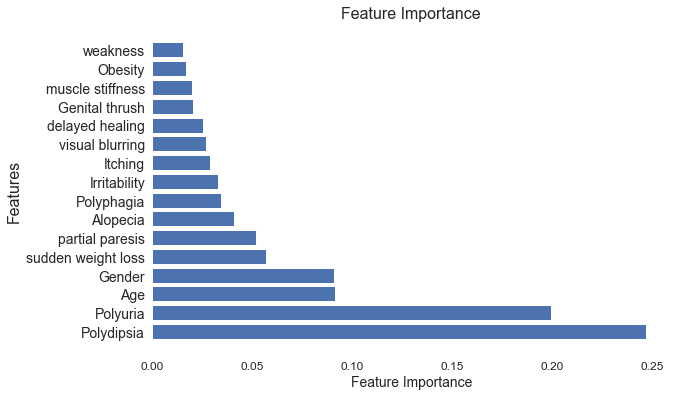

In [152]:
features = pd.DataFrame({"Importances":importances,
                  "Feature":attributes})
features_sorted_desc= features.sort_values('Importances',ascending=False)

fig = plt.figure()
plt.figure(figsize = (12,6))
plt.subplots_adjust(left=0.3)
plt.barh('Feature','Importances',data = features_sorted_desc)
plt.title('')
plt.ylabel('')
plt.xlabel('Feature Importance')
plt.title('Feature Importance', y =1.01, size = 16)

plt.yticks(fontsize=14)
fig.suptitle('', fontsize=14, fontweight='bold')
ax = plt.axes()

ax.set_facecolor('white')
ax.set_ylabel('Features', fontsize=16)

plt.savefig('Feature Importance .png')

In [57]:
xg_importances = XGB.feature_importances_

<Figure size 432x288 with 0 Axes>

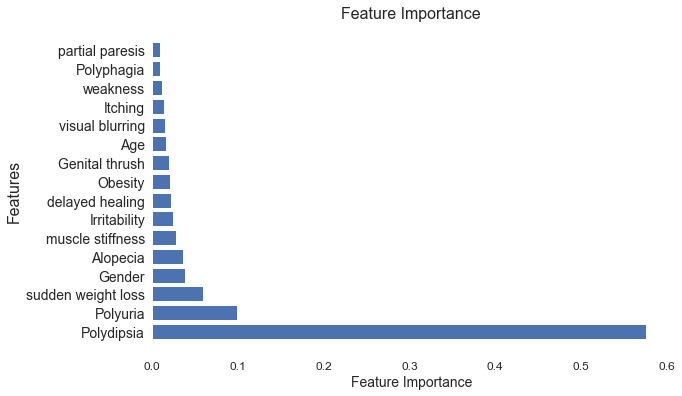

In [153]:
features = pd.DataFrame({"Importances":xg_importances,
                  "Feature":attributes})
features_sorted_desc= features.sort_values('Importances',ascending=False)

fig = plt.figure()
plt.figure(figsize = (12,6))
plt.subplots_adjust(left=0.3)
plt.barh('Feature','Importances',data = features_sorted_desc)
plt.title('')
plt.ylabel('')
plt.xlabel('Feature Importance')
plt.title('Feature Importance', y =1.01, size = 16)

plt.yticks(fontsize=14)
fig.suptitle('', fontsize=14, fontweight='bold')
ax = plt.axes()

ax.set_facecolor('white')
ax.set_ylabel('Features', fontsize=16)

plt.savefig('Feature Importance_xg .png')

In [70]:
corr  = []
for feature in data_p:
    corr.append(np.corrcoef(data_p[feature],data_labels)[0][1])
    print(feature, np.corrcoef(data_p[feature],data_labels)[0][1])

Age 0.10867899854466134
Gender -0.4492333585023052
Polyuria 0.6659224017308114
Polydipsia 0.6487337304599204
sudden weight loss 0.4365681826150604
weakness 0.24327477330369177
Polyphagia 0.34250386354385853
Genital thrush 0.11028774943290126
visual blurring 0.25130024808579376
Itching -0.01338371851114166
Irritability 0.29946706887473235
delayed healing 0.046979524748752145
partial paresis 0.43228762054052294
muscle stiffness 0.1224744871391591
Alopecia -0.2675115767280865
Obesity 0.07217333961497473


<Figure size 432x288 with 0 Axes>

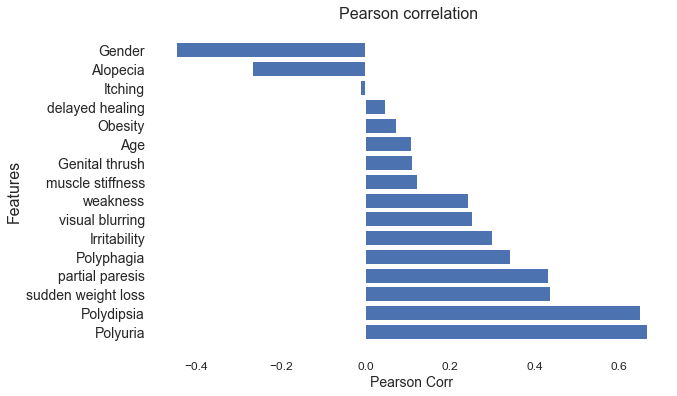

In [146]:
features = pd.DataFrame({"Pearson Corr":corr,
                  "Feature":attributes})
features_sorted_desc= features.sort_values('Pearson Corr',ascending=False)
fig = plt.figure()
plt.figure(figsize = (12,6))
plt.subplots_adjust(left=0.3)
plt.barh('Feature','Pearson Corr',data = features_sorted_desc)
plt.title('')
plt.ylabel('')
plt.xlabel('Pearson Corr')
plt.title('Pearson correlation ', y =1.01, size = 16)
plt.yticks(fontsize=14)
fig.suptitle('', fontsize=14, fontweight='bold')
ax = plt.axes()
ax.set_facecolor('white')
ax.set_ylabel('Features', fontsize=16)
plt.savefig('Pearson Correlation .png')


# Estimating the best models

In [154]:
stat_forest = []
stat_knn = []
stat_XGB = []
AUC_forest = []
AUC_knn = []
AUC_XGB = []

In [158]:
mf = []

forest = RandomForestClassifier(random_state=1)
for times in range(5):
    df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)
    param_grid = [
    # try 12 (3×4) combinations of hyperparameters
     # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [ 50,100], 'max_features': [2,3, 4], 'criterion': ['gini','entropy'],'max_depth' : [10,20]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [50,100], 'max_features': [2, 3, 4],'criterion': ['gini','entropy'],'max_depth' : [10,20]},
  ]
    grid = GridSearchCV(forest,param_grid, cv=10,return_train_score=True) 
    
    
    

    
    grid.fit(df_train,train_labels)
    forest = grid.best_estimator_
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
    mf.append(forest)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3))    

  Mean AUC  0.999   Mean ACC  0.983


In [159]:
t = zip(mf,AUC_forest, stat_forest)
print(list(t))

[(RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_features=3, n_estimators=50, random_state=1), 0.9988038277511961, 0.9807692307692307), (RandomForestClassifier(bootstrap=False, max_depth=10, max_features=2,
                       n_estimators=50, random_state=1), 1.0, 1.0), (RandomForestClassifier(bootstrap=False, max_depth=10, max_features=2,
                       random_state=1), 0.9996159754224271, 0.9807692307692307), (RandomForestClassifier(bootstrap=False, max_depth=20, max_features=2,
                       random_state=1), 0.9995966115369099, 0.9807692307692307), (RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       max_features=2, n_estimators=50, random_state=1), 0.9992257065427798, 0.9807692307692307)]


In [161]:
kn = []
knn = KNeighborsClassifier()
for times in range(5):
    df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)    
    param_grid = [
        # try 12 (3×4) combinations of hyperparameters
        {'n_neighbors': [ 3,5,11,19], 'weights': ['uniforn','distance'], 'metric': ['minkowski','manhattan','euclidean']},
        # then try 6 (2×3) combinations with bootstrap set as False
        #{'bootstrap': [False], 'n_estimators': [50,100,200], 'max_features': [2, 3, 4],'criterion': ['gini','entropy']},
     ]


    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    grid = GridSearchCV(knn, param_grid, cv=20, return_train_score=True)                       

    grid.fit(df_train,train_labels)

    knn2 = grid.best_estimator_
    g_probs = knn2.predict_proba(df_test)[:, 1]
    knn_auc = roc_auc_score(test_labels,g_probs)   
    stat_knn.append(knn2.score(df_test, test_labels))
    
    AUC_knn.append(knn_auc)
    kn.append(knn2)

k = zip(kn,AUC_knn, stat_knn)
print(list(k))

[(KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'), 0.958984375, 0.9519230769230769), (KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'), 0.9823838080959522, 0.9807692307692307), (KNeighborsClassifier(n_neighbors=3, weights='distance'), 0.9767441860465117, 0.9326923076923077), (KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'), 0.9511562998405103, 0.9423076923076923), (KNeighborsClassifier(metric='manhattan', weights='distance'), 0.9552795031055901, 0.9230769230769231)]


In [162]:
xg = []
XGB = XGBClassifier(use_label_encoder=False, eval_metric = 'auc')
for times in range(10):
    df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)    
    param_grid = [
         
    { 'gamma': [0,1,5],
              'learning_rate': [0.01, 0.1],
              'max_depth': [10,20],
              'n_estimators': [50,100],
              }
 ]


    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    XGBCL = GridSearchCV(XGB, param_grid, cv=10, return_train_score=True)                       

    XGBCL.fit(df_train,train_labels)

    XGB = XGBCL.best_estimator_
    g_probs = XGB.predict_proba(df_test)[:, 1]
    XGB_auc = roc_auc_score(test_labels,g_probs)   
    stat_XGB.append(XGB.score(df_test, test_labels))
    
    AUC_XGB.append(XGB_auc)
    xg.append(XGB)

x = zip(xg,AUC_XGB, stat_XGB)
print(list(x))

[(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None), 0.9957757296466974, 0.9903846153846154), (XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weigh

In [164]:
from prettytable                     import PrettyTable
from astropy.table                   import Table, Column


# Running the models 100-200 times to evaluate overall performance

#### Machine learning models

In [204]:


forest = RandomForestClassifier(random_state = 1,bootstrap = False, criterion= 'gini',max_depth = 10, max_features= 2, n_estimators= 50)

knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors= 3, weights = 'distance')

XGB = XGBClassifier(use_label_encoder=False, eval_metric = 'auc',gamma= 0, learning_rate= 0.1, max_depth= 10, n_estimators= 100)
#Voting classifier on all the best models
voting_clf = VotingClassifier(
 estimators=[('forest', forest), ('knn', knn), ('xgb', XGB)],
 voting='soft'
 )
stat_forest = []
stat_knn = []
stat_XGB = []
stat_vc = []
AUC_forest = []
AUC_knn = []
AUC_XGB = []
AUC_vc = []
prec_forest=[]
prec_knn = []
prec_XGB =[]
prec_vc =[]
recall_forest=[]
recall_knn = []
recall_XGB =[]
recall_vc =[]

for times in range(300):
    df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    forest_pred = forest.predict(df_test)
    
    
    #print('Forest:')
    #print('Train accuracy: {}'.format(forest.score(df_train, train_labels)))
    #print('Test accuracy: {}'.format(forest.score(df_test, test_labels)))
     
    knn.fit(df_train,train_labels)
    k_probs = knn.predict_proba(df_test)[:, 1]
    knn_auc = roc_auc_score(test_labels,k_probs)
    knn_pred = knn.predict(df_test)
    #print('KNN:')
    #print('Train accuracy: {}'.format(knn.score(df_train, train_labels)))
    #print('Test accuracy: {}'.format(knn.score(df_test, test_labels)))
      
    XGB.fit(df_train,train_labels)
    XGB_pred = XGB.predict(df_test)
    X_probs = knn.predict_proba(df_test)[:, 1]
    XGB_auc = roc_auc_score(test_labels,X_probs)
    #accuracy = accuracy_score(test_labels, y_pred)
    #print('XGBoost:')
    #print('Train accuracy: {}'.format(XGB.score(df_train, train_labels)))
    #print('Test accuracy: {}'.format(XGB.score(df_test, test_labels)))
    
    voting_clf.fit(df_train,train_labels)
    vc_pred = voting_clf.predict(df_test)
    vc_probs = voting_clf.predict_proba(df_test)[:, 1]
    vc_auc = roc_auc_score(test_labels,vc_probs)
    
    
    stat_forest.append(forest.score(df_test, test_labels))
    stat_knn.append(knn.score(df_test, test_labels))
    stat_XGB.append(accuracy_score(test_labels, XGB_pred))
    stat_vc.append(voting_clf.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
    AUC_knn.append(knn_auc)
    AUC_XGB.append(XGB_auc)
    AUC_vc.append(vc_auc)
    
    prec_forest.append(precision_score(test_labels, forest_pred))
    prec_knn.append(precision_score(test_labels, knn_pred))
    prec_XGB.append(precision_score(test_labels, XGB_pred))
    prec_vc.append(precision_score(test_labels, vc_pred))
    
    recall_forest.append(recall_score(test_labels, forest_pred))
    recall_knn.append(recall_score(test_labels, knn_pred))
    recall_XGB.append(recall_score(test_labels, XGB_pred))
    recall_vc.append(recall_score(test_labels, vc_pred))

In [205]:
from prettytable                     import PrettyTable
from astropy.table                   import Table, Column
Model_Table = PrettyTable()
Model_Table.field_names = [" ", "   Random forest Classififier  ", "     K-Nearest Neighbours       ", "     XGBoost       ", "Voting classifier"]
Model_Table.add_row(["  Max  ", round(max(stat_forest),3), round(max(stat_knn),3), round(max(stat_XGB),3),round(max(stat_vc),3)])
Model_Table.add_row(["  Min  ", round(min(stat_forest),3),round(min(stat_knn),3),round(min(stat_XGB),3),round(min(stat_vc),3)])
Model_Table.add_row(["  Mean  ", round(stats.mean(stat_forest),3),round(stats.mean(stat_knn),3),round(stats.mean(stat_XGB),3),round(stats.mean(stat_vc),3)])
Model_Table.add_row(["  StDev  ", round(stats.stdev(stat_forest),3),round(stats.stdev(stat_knn),3),round(stats.stdev(stat_XGB),3),round(stats.stdev(stat_vc),3)])
print("Detailed accuracy performance of all models:")
print(Model_Table)#

Detailed accuracy performance of all models:
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|           |    Random forest Classififier   |      K-Nearest Neighbours        |      XGBoost        | Voting classifier |
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|    Max    |               1.0               |               1.0                |         1.0         |        1.0        |
|    Min    |              0.933              |              0.894               |        0.894        |       0.913       |
|    Mean   |              0.986              |              0.962               |         0.97        |       0.976       |
|   StDev   |              0.012              |              0.018               |        0.017        |       0.015       |
+-----------+---------------------------------+---------------------------------

In [206]:
Model_Table2 = PrettyTable()
Model_Table2.field_names = [" ", "   Random forest Classififier  ", "     K-Nearest Neighbours       ", "     XGBoost       ", "Voting Classifier"]
Model_Table2.add_row(["  Max  ", round(max(AUC_forest),3), round(max(AUC_knn),3), round(max(AUC_XGB),3),round(max(AUC_vc),3)])
Model_Table2.add_row(["  Min  ", round(min(AUC_forest),3),round(min(AUC_knn),3),round(min(AUC_XGB),3),round(min(AUC_vc),3)])
Model_Table2.add_row(["  Mean  ", round(stats.mean(AUC_forest),3),round(stats.mean(AUC_knn),3),round(stats.mean(AUC_XGB),3),round(stats.mean(AUC_vc),3)])
Model_Table2.add_row(["  StDev  ", round(stats.stdev(AUC_forest),3),round(stats.stdev(AUC_knn),3),round(stats.stdev(AUC_XGB),3),round(stats.stdev(AUC_vc),3)])

print("Detailed AUC performance of all models:")
print(Model_Table2)#

Detailed AUC performance of all models:
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|           |    Random forest Classififier   |      K-Nearest Neighbours        |      XGBoost        | Voting Classifier |
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|    Max    |               1.0               |               1.0                |         1.0         |        1.0        |
|    Min    |              0.987              |              0.904               |        0.904        |       0.984       |
|    Mean   |              0.999              |              0.985               |        0.985        |       0.999       |
|   StDev   |              0.002              |              0.012               |        0.012        |       0.002       |
+-----------+---------------------------------+----------------------------------+---

In [207]:
from prettytable                     import PrettyTable
from astropy.table                   import Table, Column
Model_Table = PrettyTable()
Model_Table.field_names = [" ", "   Random forest Classififier  ", "     K-Nearest Neighbours       ", "     XGBoost       ", "Voting classifier"]
Model_Table.add_row(["  Max  ", round(max(prec_forest),3), round(max(prec_knn),3), round(max(prec_XGB),3),round(max(prec_vc),3)])
Model_Table.add_row(["  Min  ", round(min(prec_forest),3),round(min(prec_knn),3),round(min(prec_XGB),3),round(min(prec_vc),3)])
Model_Table.add_row(["  Mean  ", round(stats.mean(prec_forest),3),round(stats.mean(prec_knn),3),round(stats.mean(prec_XGB),3),round(stats.mean(prec_vc),3)])
Model_Table.add_row(["  StDev  ", round(stats.stdev(prec_forest),3),round(stats.stdev(prec_knn),3),round(stats.stdev(prec_XGB),3),round(stats.stdev(prec_vc),3)])
print("Detailed precision performance of all models:")
print(Model_Table)#

Detailed precision performance of all models:
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|           |    Random forest Classififier   |      K-Nearest Neighbours        |      XGBoost        | Voting classifier |
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|    Max    |               1.0               |               1.0                |         1.0         |        1.0        |
|    Min    |              0.918              |              0.929               |        0.912        |       0.921       |
|    Mean   |              0.986              |              0.995               |        0.984        |       0.989       |
|   StDev   |              0.016              |              0.011               |        0.017        |       0.014       |
+-----------+---------------------------------+--------------------------------

In [208]:
from prettytable                     import PrettyTable
from astropy.table                   import Table, Column
Model_Table = PrettyTable()
Model_Table.field_names = [" ", "   Random forest Classififier  ", "     K-Nearest Neighbours       ", "     XGBoost       ", "Voting classifier"]
Model_Table.add_row(["  Max  ", round(max(recall_forest),3), round(max(recall_knn),3), round(max(recall_XGB),3),round(max(recall_vc),3)])
Model_Table.add_row(["  Min  ", round(min(recall_forest),3),round(min(recall_knn),3),round(min(recall_XGB),3),round(min(recall_vc),3)])
Model_Table.add_row(["  Mean  ", round(stats.mean(recall_forest),3),round(stats.mean(recall_knn),3),round(stats.mean(recall_XGB),3),round(stats.mean(recall_vc),3)])
Model_Table.add_row(["  StDev  ", round(stats.stdev(recall_forest),3),round(stats.stdev(recall_knn),3),round(stats.stdev(recall_XGB),3),round(stats.stdev(recall_vc),3)])
print("Detailed recall performance of all models:")
print(Model_Table)#

Detailed recall performance of all models:
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|           |    Random forest Classififier   |      K-Nearest Neighbours        |      XGBoost        | Voting classifier |
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|    Max    |               1.0               |               1.0                |         1.0         |        1.0        |
|    Min    |              0.945              |               0.87               |        0.883        |       0.903       |
|    Mean   |              0.991              |              0.943               |        0.966        |       0.972       |
|   StDev   |              0.012              |              0.027               |        0.023        |        0.02       |
+-----------+---------------------------------+----------------------------------+

### Multilayer Neural Network

Model: "sequential_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_962 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_480 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_963 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_481 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_964 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_965 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

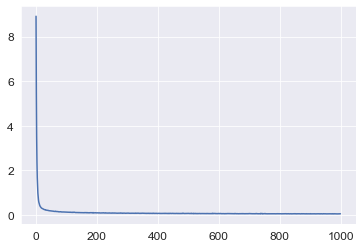

Model: "sequential_242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_966 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_482 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_967 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_483 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_968 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_969 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

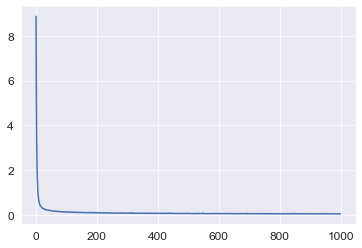

Model: "sequential_243"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_970 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_484 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_971 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_485 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_972 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_973 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

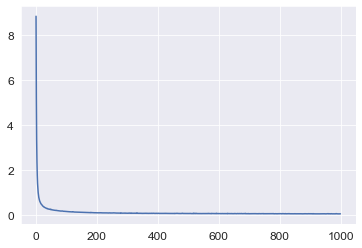

Model: "sequential_244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_974 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_486 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_975 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_487 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_976 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_977 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

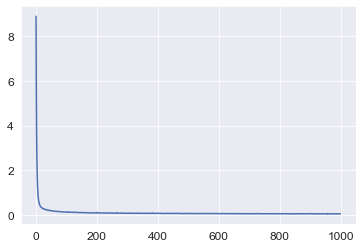

Model: "sequential_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_978 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_488 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_979 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_489 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_980 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_981 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

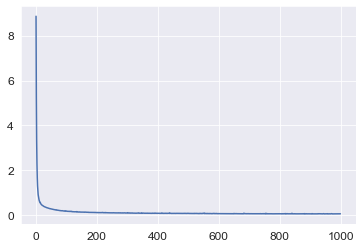

Model: "sequential_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_982 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_490 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_983 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_491 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_984 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_985 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

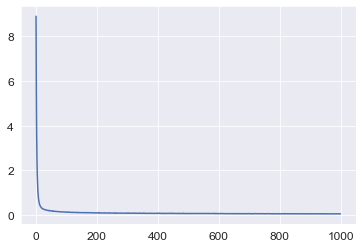

Model: "sequential_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_986 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_492 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_987 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_493 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_988 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_989 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

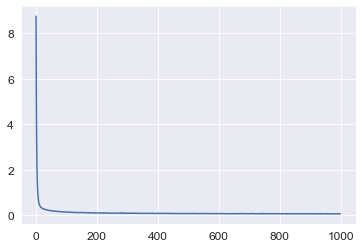

Model: "sequential_248"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_990 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_494 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_991 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_495 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_992 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_993 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

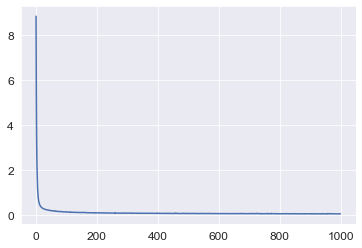

Model: "sequential_249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_994 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_496 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_995 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_497 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_996 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_997 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

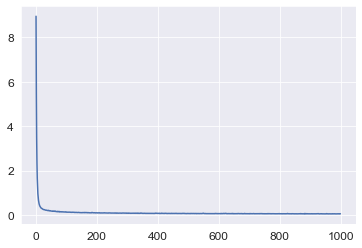

Model: "sequential_250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_998 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_498 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_999 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_499 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1000 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1001 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

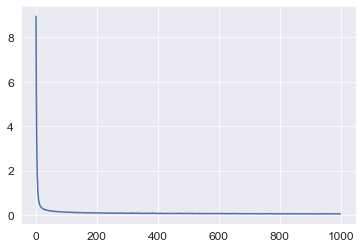

Model: "sequential_251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1002 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_500 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1003 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_501 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1004 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1005 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

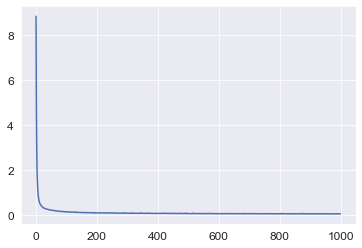

Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1006 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_502 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1007 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_503 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1008 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1009 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

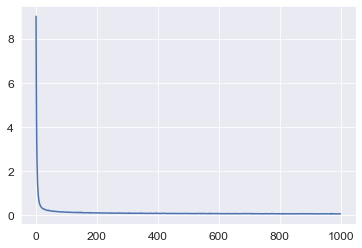

Model: "sequential_253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1010 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_504 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1011 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_505 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1012 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1013 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

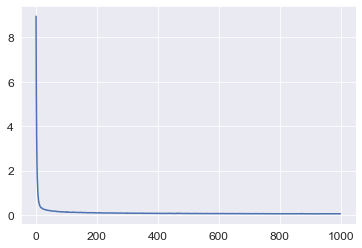

Model: "sequential_254"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1014 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_506 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1015 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_507 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1016 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1017 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

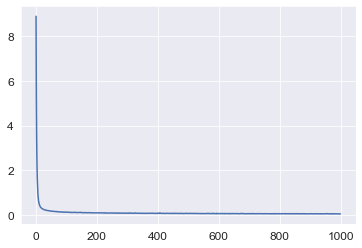

Model: "sequential_255"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1018 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_508 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1019 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_509 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1020 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1021 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

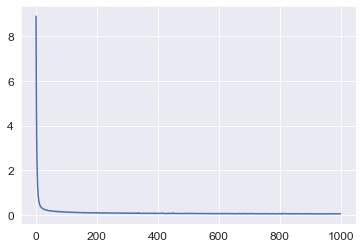

Model: "sequential_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1022 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_510 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1023 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_511 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1024 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1025 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

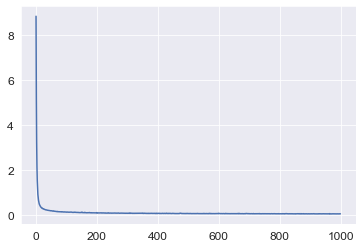

Model: "sequential_257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1026 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_512 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1027 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_513 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1028 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1029 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

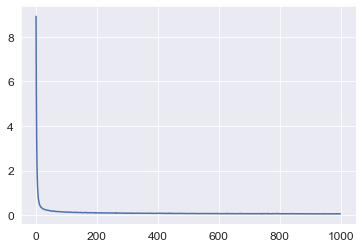

Model: "sequential_258"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1030 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_514 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1031 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_515 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1032 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1033 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

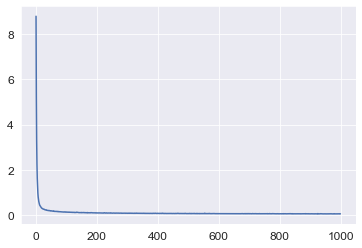

Model: "sequential_259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1034 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_516 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1035 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_517 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1036 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1037 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

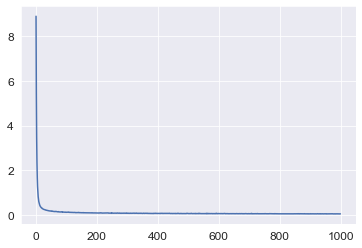

Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1038 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_518 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1039 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_519 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1040 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1041 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

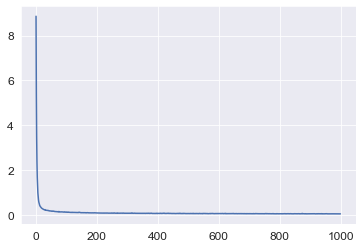

Model: "sequential_261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1042 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_520 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1043 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_521 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1044 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1045 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

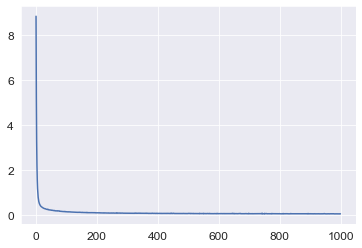

Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1046 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_522 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1047 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_523 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1048 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1049 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

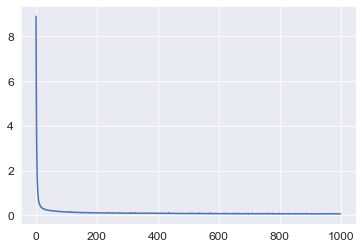

Model: "sequential_263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1050 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_524 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1051 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_525 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1052 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1053 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

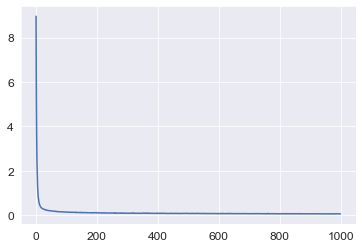

Model: "sequential_264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1054 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_526 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1055 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_527 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1056 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1057 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

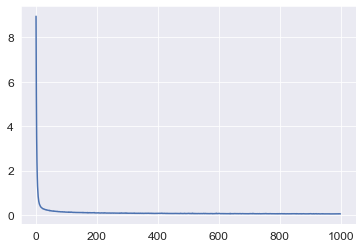

Model: "sequential_265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1058 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_528 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1059 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_529 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1060 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1061 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

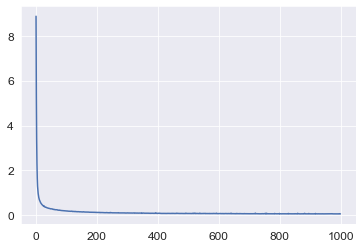

Model: "sequential_266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1062 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_530 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1063 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_531 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1064 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1065 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

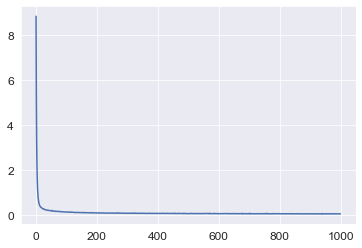

Model: "sequential_267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1066 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_532 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1067 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_533 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1068 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1069 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

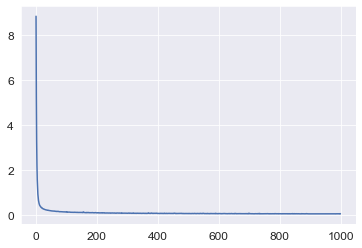

Model: "sequential_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1070 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_534 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1071 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_535 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1072 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1073 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

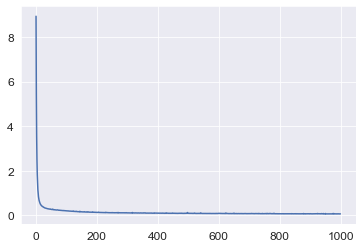

Model: "sequential_269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1074 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_536 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1075 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_537 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1076 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1077 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

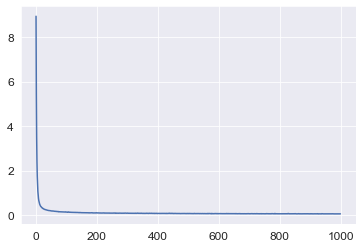

Model: "sequential_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1078 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_538 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1079 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_539 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1080 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1081 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

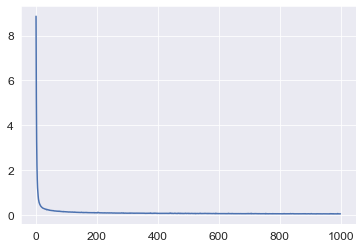

Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1082 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_540 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1083 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_541 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1084 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1085 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

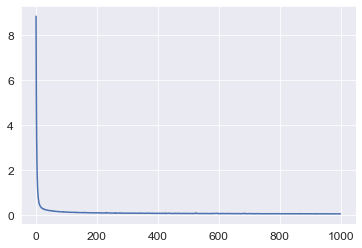

Model: "sequential_272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1086 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_542 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1087 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_543 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1088 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1089 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

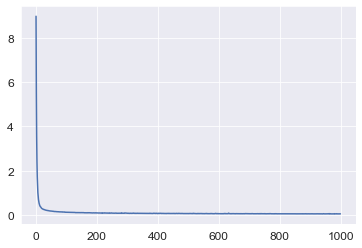

Model: "sequential_273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1090 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_544 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1091 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_545 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1092 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1093 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

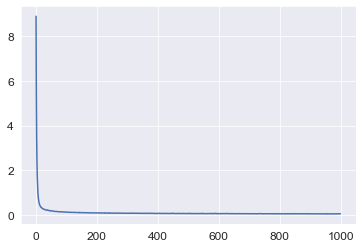

Model: "sequential_274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1094 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_546 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1095 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_547 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1096 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1097 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

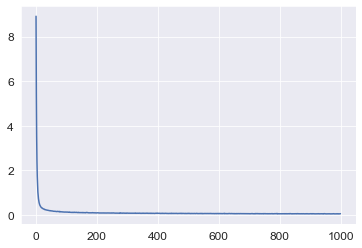

Model: "sequential_275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1098 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_548 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1099 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_549 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1100 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1101 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

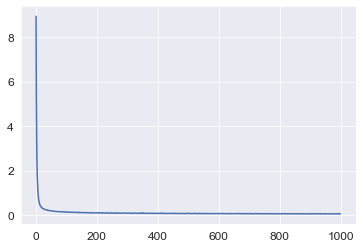

Model: "sequential_276"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1102 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_550 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1103 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_551 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1104 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1105 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

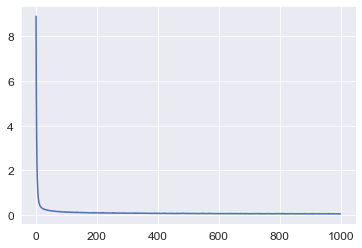

Model: "sequential_277"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1106 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_552 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1107 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_553 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1108 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1109 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

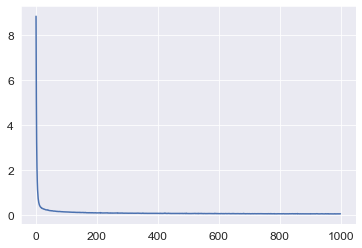

Model: "sequential_278"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1110 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_554 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1111 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_555 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1112 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1113 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

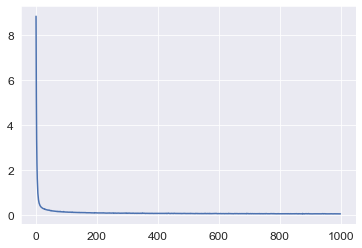

Model: "sequential_279"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1114 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_556 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1115 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_557 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1116 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1117 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

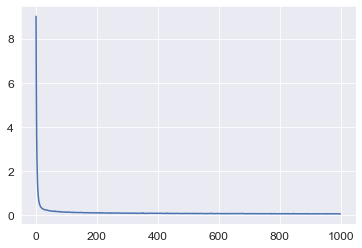

Model: "sequential_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1118 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_558 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1119 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_559 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1120 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1121 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

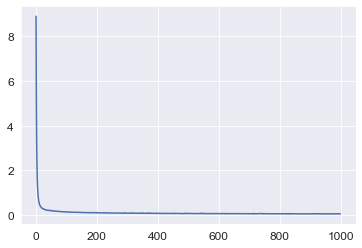

Model: "sequential_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1122 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_560 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1123 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_561 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1124 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1125 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

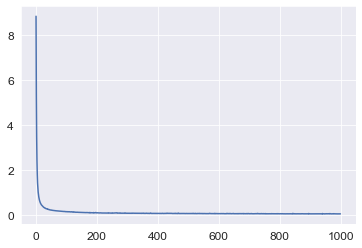

Model: "sequential_282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1126 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_562 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1127 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_563 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1128 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1129 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

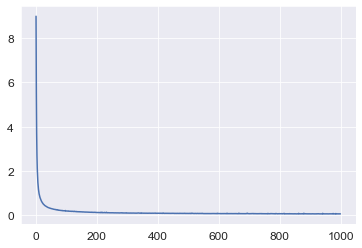

Model: "sequential_283"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1130 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_564 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1131 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_565 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1132 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1133 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

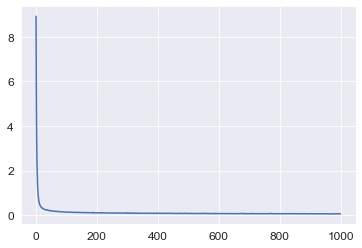

Model: "sequential_284"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1134 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_566 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1135 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_567 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1136 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1137 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

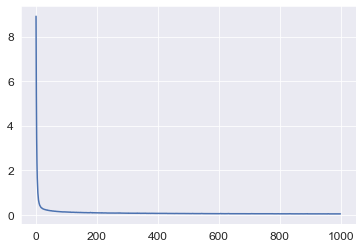

Model: "sequential_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1138 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_568 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1139 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_569 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1140 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1141 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

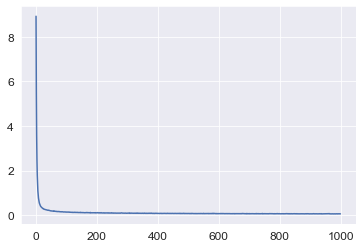

Model: "sequential_286"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1142 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_570 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1143 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_571 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1144 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1145 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

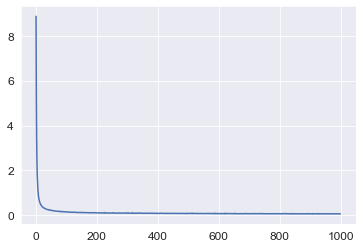

Model: "sequential_287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1146 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_572 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1147 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_573 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1148 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1149 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

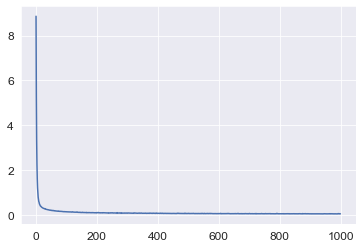

Model: "sequential_288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1150 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_574 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1151 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_575 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1152 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1153 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

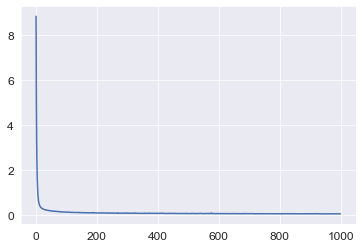

Model: "sequential_289"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1154 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_576 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1155 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_577 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1156 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1157 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

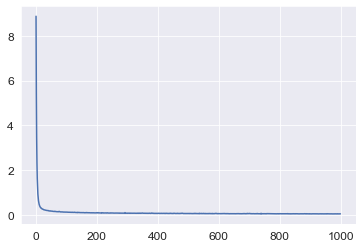

Model: "sequential_290"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1158 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_578 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1159 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_579 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1160 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1161 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

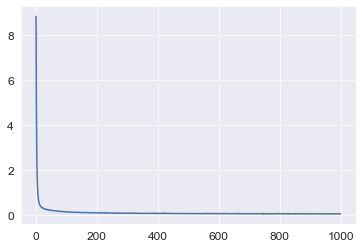

Model: "sequential_291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1162 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_580 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1163 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_581 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1164 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1165 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

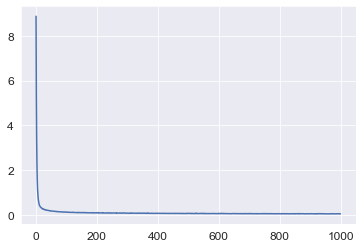

Model: "sequential_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1166 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_582 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1167 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_583 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1168 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1169 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

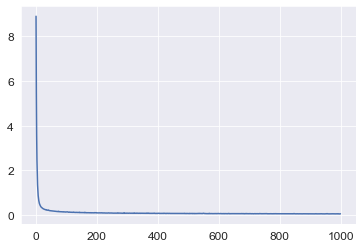

Model: "sequential_293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1170 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_584 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1171 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_585 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1172 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1173 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

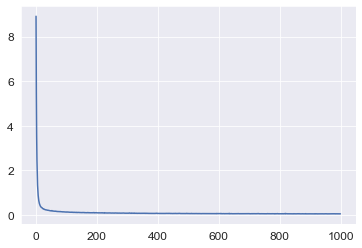

Model: "sequential_294"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1174 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_586 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1175 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_587 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1176 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1177 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

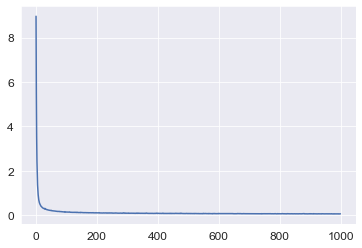

Model: "sequential_295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1178 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_588 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1179 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_589 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1180 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1181 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

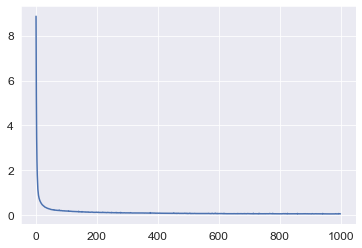

Model: "sequential_296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1182 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_590 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1183 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_591 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1184 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1185 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

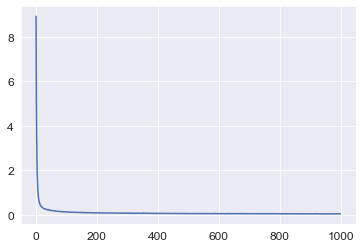

Model: "sequential_297"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1186 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_592 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1187 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_593 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1188 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1189 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

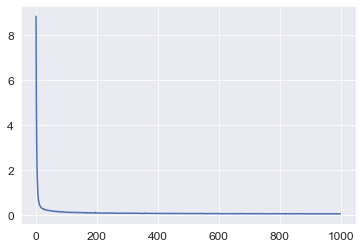

Model: "sequential_298"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1190 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_594 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1191 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_595 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1192 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1193 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

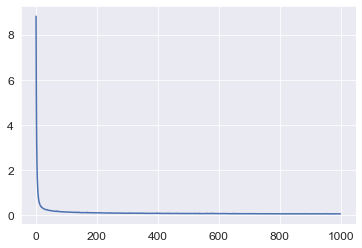

Model: "sequential_299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1194 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_596 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1195 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_597 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1196 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1197 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

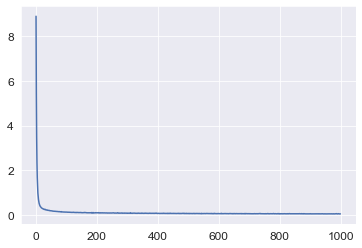

Model: "sequential_300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1198 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_598 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1199 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_599 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1200 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1201 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

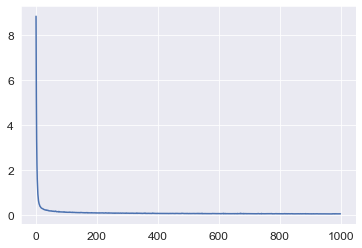

Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1202 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_600 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1203 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_601 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1204 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1205 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

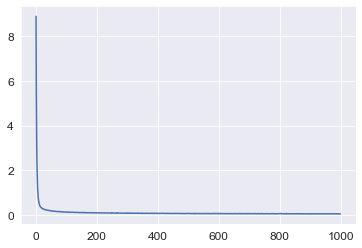

Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1206 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_602 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1207 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_603 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1208 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1209 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

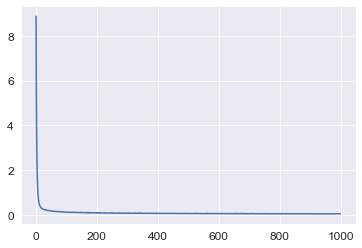

Model: "sequential_303"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1210 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_604 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1211 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_605 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1212 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1213 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

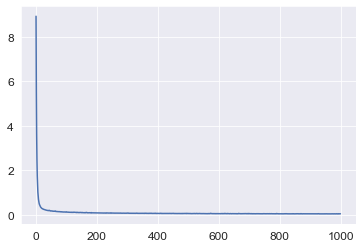

Model: "sequential_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1214 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_606 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1215 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_607 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1216 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1217 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

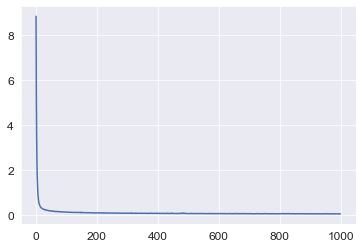

Model: "sequential_305"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1218 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_608 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1219 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_609 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1220 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1221 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

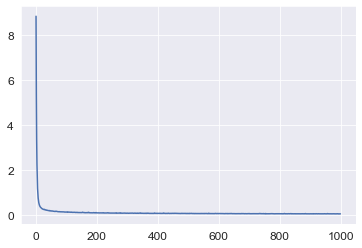

Model: "sequential_306"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1222 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_610 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1223 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_611 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1224 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1225 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

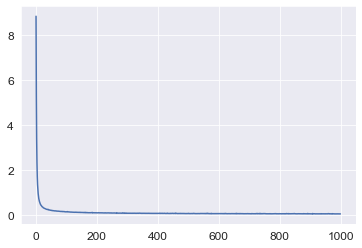

Model: "sequential_307"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1226 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_612 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1227 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_613 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1228 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1229 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

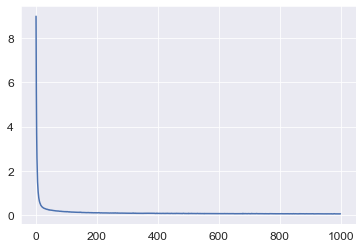

Model: "sequential_308"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1230 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_614 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1231 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_615 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1232 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1233 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

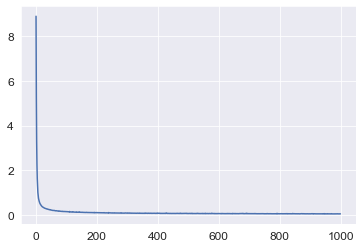

Model: "sequential_309"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1234 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_616 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1235 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_617 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1236 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1237 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

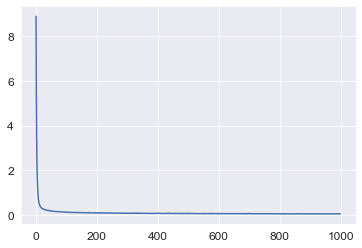

Model: "sequential_310"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1238 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_618 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1239 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_619 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1240 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1241 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

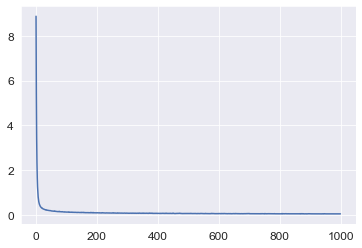

Model: "sequential_311"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1242 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_620 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1243 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_621 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1244 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1245 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

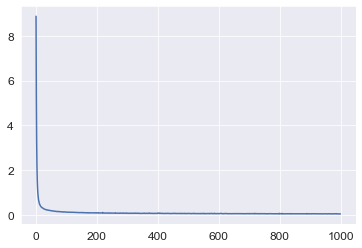

Model: "sequential_312"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1246 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_622 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1247 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_623 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1248 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1249 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

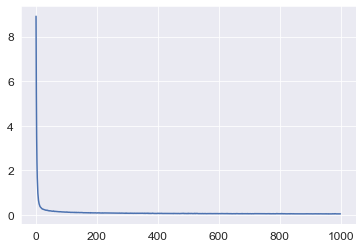

Model: "sequential_313"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1250 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_624 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1251 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_625 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1252 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1253 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

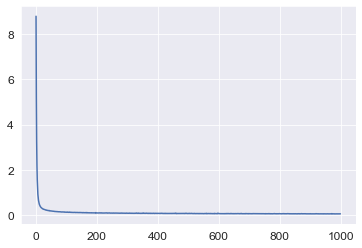

Model: "sequential_314"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1254 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_626 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1255 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_627 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1256 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1257 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

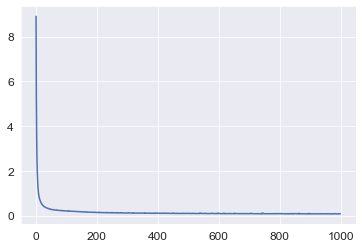

Model: "sequential_315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1258 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_628 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1259 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_629 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1260 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1261 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

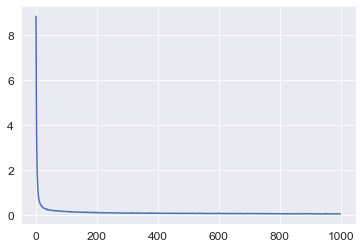

Model: "sequential_316"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1262 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_630 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1263 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_631 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1264 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1265 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

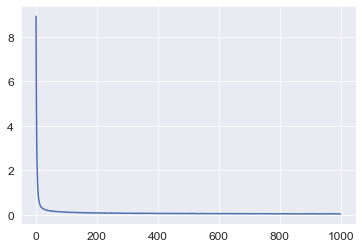

Model: "sequential_317"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1266 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_632 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1267 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_633 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1268 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1269 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

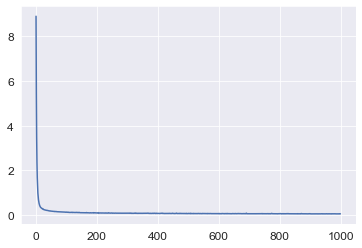

Model: "sequential_318"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1270 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_634 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1271 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_635 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1272 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1273 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

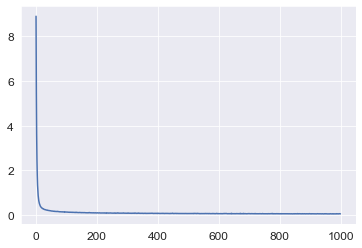

Model: "sequential_319"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1274 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_636 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1275 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_637 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1276 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1277 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

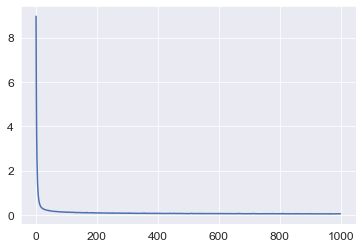

Model: "sequential_320"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1278 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_638 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1279 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_639 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1280 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1281 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

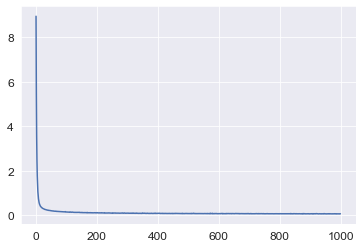

Model: "sequential_321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1282 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_640 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1283 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_641 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1284 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1285 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

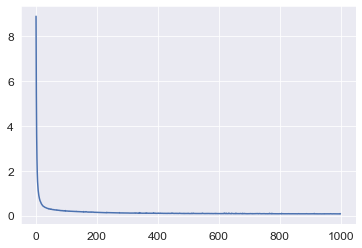

Model: "sequential_322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1286 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_642 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1287 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_643 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1288 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1289 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

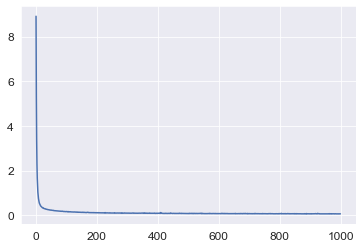

Model: "sequential_323"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1290 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_644 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1291 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_645 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1292 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1293 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

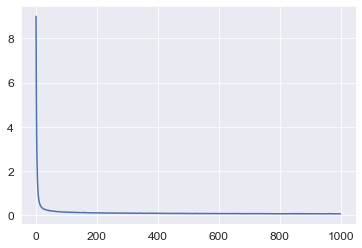

Model: "sequential_324"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1294 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_646 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1295 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_647 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1296 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1297 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

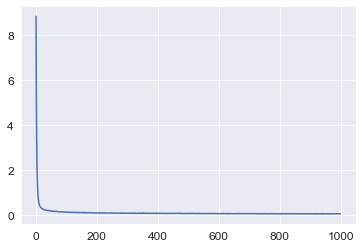

Model: "sequential_325"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1298 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_648 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1299 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_649 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1300 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1301 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

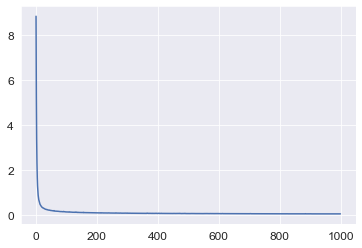

Model: "sequential_326"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1302 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_650 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1303 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_651 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1304 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1305 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

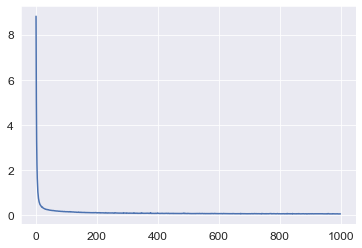

Model: "sequential_327"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1306 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_652 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1307 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_653 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1308 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1309 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

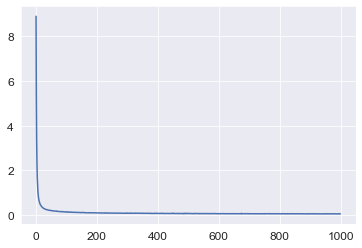

Model: "sequential_328"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1310 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_654 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1311 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_655 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1312 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1313 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

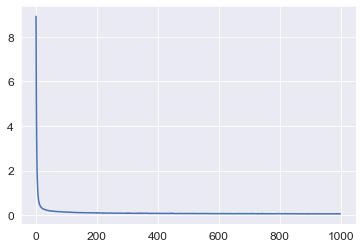

Model: "sequential_329"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1314 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_656 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1315 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_657 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1316 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1317 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

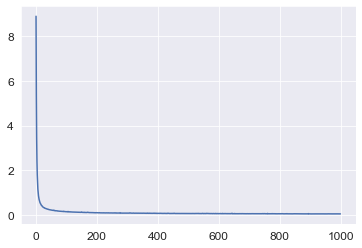

Model: "sequential_330"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1318 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_658 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1319 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_659 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1320 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1321 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

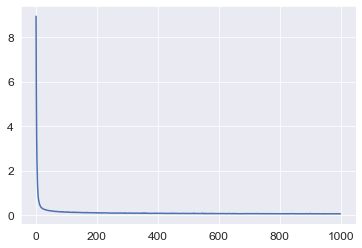

Model: "sequential_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1322 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_660 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1323 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_661 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1324 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1325 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

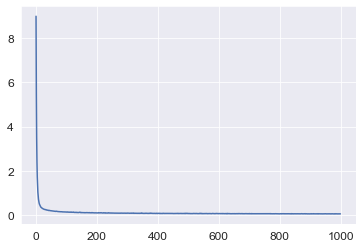

Model: "sequential_332"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1326 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_662 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1327 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_663 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1328 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1329 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

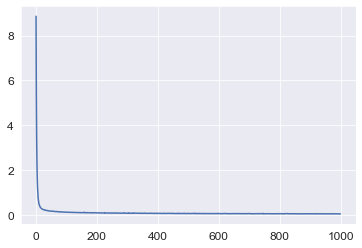

Model: "sequential_333"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1330 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_664 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1331 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_665 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1332 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1333 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

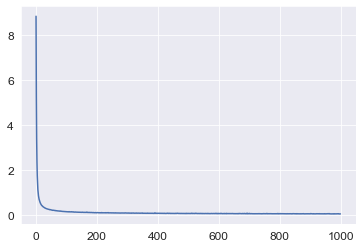

Model: "sequential_334"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1334 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_666 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1335 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_667 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1336 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1337 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

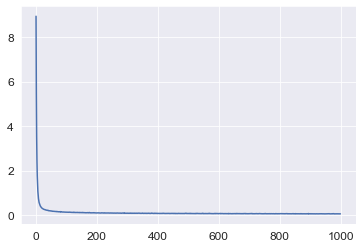

Model: "sequential_335"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1338 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_668 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1339 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_669 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1340 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1341 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

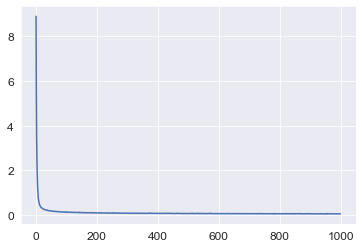

Model: "sequential_336"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1342 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_670 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1343 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_671 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1344 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1345 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

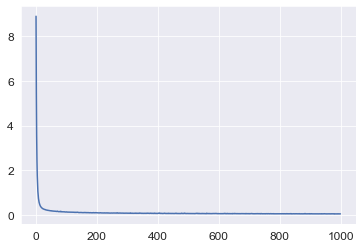

Model: "sequential_337"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1346 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_672 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1347 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_673 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1348 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1349 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

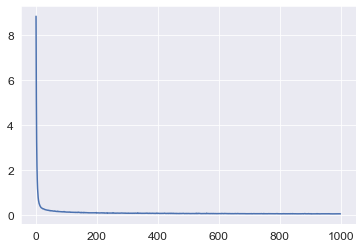

Model: "sequential_338"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1350 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_674 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1351 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_675 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1352 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1353 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

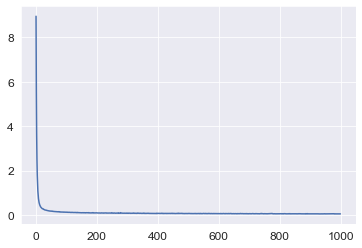

Model: "sequential_339"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1354 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_676 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1355 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_677 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1356 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1357 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

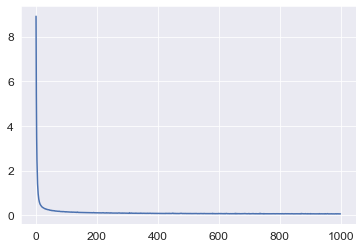

Model: "sequential_340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1358 (Dense)           (None, 512)               8704      
_________________________________________________________________
dropout_678 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1359 (Dense)           (None, 512)               262656    
_________________________________________________________________
dropout_679 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_1360 (Dense)           (None, 512)               262144    
_________________________________________________________________
dense_1361 (Dense)           (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
______________________________________________

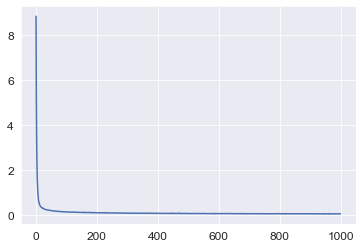

Detailed accuracy performance of MLNN:
+-----------+--------------------+---------------+--------------------+---------------+
|           |    Loss function   |      AUC      |     Accuracy       |     Recall    |
+-----------+--------------------+---------------+--------------------+---------------+
|    Max    |       0.321        |      1.0      |        1.0         |      1.0      |
|    Min    |       0.049        |     0.953     |       0.913        |      0.85     |
|    Mean   |       0.136        |     0.993     |       0.967        |     0.967     |
|   StDev   |       0.058        |     0.009     |       0.017        |     0.027     |
+-----------+--------------------+---------------+--------------------+---------------+


In [215]:

#Neural Network Hyperparameters

np.random.seed(1)
ml_loss = []
ml_auc = []
ml_accuracy = []
ml_precision = []
ml_recall = [] 
for times in range(100):
    X_train, X_test, y_train, y_test = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    X_train,y_train = smote.fit_resample(X_train,y_train)
    input_dim = 16
    num_classes = 1
    num_epochs = 1000
    layer_dim = 1
    learning_rate = 0.001
    batch_size =32#int(opt)32
    dropout=0.05
    hidden_dim=512
    output_activation = 'sigmoid'
    initial_activation = 'relu'
    kernel_initializer="glorot_uniform"
    bias_initializer="glorot_uniform"
    loss_function=tf.keras.losses.BinaryCrossentropy()
    optimiser=optimizers.Adamax(lr=learning_rate)
    metric=tf.keras.metrics.AUC()#,tf.keras.metrics.Accuracy()
    kernel_regularizer='l2'#,'l1_l2'
    
    ##Building the MLP
            
    history = History()
    model = Sequential()
    
    #Add input layer
    model.add(Dense(hidden_dim, input_dim=input_dim, activation=initial_activation, use_bias=True, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
    model.add(Dropout(dropout))
    #Add hidden layer
    model.add(Dense(hidden_dim, activation=initial_activation, use_bias=True, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
    model.add(Dropout(dropout))
    #Add hidden layer
    model.add(Dense(hidden_dim, activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
    
    #Add output layer
    model.add(Dense(units=num_classes, activation=output_activation))
       
    sgd=optimizers.Adamax(lr=learning_rate)     
    model.compile(loss=loss_function,
                  optimizer=optimiser,
                  metrics=[metric,'accuracy']) 
    print(model.summary())
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 300)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0, callbacks=[callback, history])
    plt.plot(history.history['loss'], label='train')
    plt.show()
    mnn_pred = model.predict_classes(X_test)
    #Model Evaluation
    score =(loss, AUC,accuracy) = model.evaluate(X_test, y_test, verbose=0)
    #y_pred=model.predict(X_test)
    #print('Test AUC (from sklearn):',custom_auc(y_test, y_pred))
    ml_loss.append(score[0])
    ml_auc.append(score[1])
    ml_accuracy.append(score[2])
    ml_precision.append(precision_score(y_test, mnn_pred))
    ml_recall.append(recall_score(y_test, mnn_pred))
    #print('Test loss:',score[0])
    #print('Test AUC (from tf):',score[1])
    #print('Test accuracy:',score[2])
# calculate testing accuracy
#print(ml_loss,ml_auc,ml_accuracy)

Model_Table = PrettyTable()
Model_Table.field_names = [" ", "   Loss function  ", "     AUC     ", "    Accuracy      ","    Recall   "]
Model_Table.add_row(["  Max  ", round(max(ml_loss),3), round(max(ml_auc),3), round(max(ml_accuracy),3),round(max(ml_recall),3)])
Model_Table.add_row(["  Min  ", round(min(ml_loss),3),round(min(ml_auc),3),round(min(ml_accuracy),3),round(min(ml_recall),3)])
Model_Table.add_row(["  Mean  ", round(stats.mean(ml_loss),3),round(stats.mean(ml_auc),3),round(stats.mean(ml_accuracy),3),round(stats.mean(ml_recall),3)])
Model_Table.add_row(["  StDev  ", round(stats.stdev(ml_loss),3),round(stats.stdev(ml_auc),3),round(stats.stdev(ml_accuracy),3),round(stats.stdev(ml_recall),3)])
print("Detailed accuracy performance of MLNN:")
print(Model_Table)#

# Feature Selection

In [90]:
#Forest parameter 
from sklearn.feature_selection import SelectFromModel

From pearson correlation coefficient we had that itching is the least correlated with our outcome and from feature selection we had that weakness and obesity are least important. We will try and remove each of those and see how the Randon Forest classifier will perform, as it is the algorythm with the best performance.

In [173]:
forest = RandomForestClassifier(random_state=1)
# Drop itching
data_sel = data_p.drop('Itching', axis = 1)
#drop weakness
data_sel1 = data_p.drop('weakness', axis = 1)
#drop itching and delayed healing
data_sel2 = data_p.drop(['weakness','Obesity'], axis = 1)
#drop itching, delayed healing and obesity 
data_sel3 = data_p.drop(['Itching','delayed healing', 'Obesity'], axis = 1)

In [174]:
stat_forest = []

AUC_forest = []
forest = RandomForestClassifier(random_state=1, criterion= 'gini', max_features= 2, n_estimators= 50)
for times in range(200):
    df_train, df_test,train_labels,test_labels = train_test_split(data_sel, data_labels, train_size = 0.8, shuffle=True)
    #df_train,train_labels = smote.fit_resample(df_train,train_labels)
    
    
    
    
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3)) 
    

  Mean AUC  0.999   Mean ACC  0.981


In [175]:
stat_forest = []

AUC_forest = []
forest = RandomForestClassifier(random_state=1, criterion= 'gini', max_features= 2, n_estimators= 50)
for times in range(200):
    df_train, df_test,train_labels,test_labels = train_test_split(data_sel1, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)
    
    
    
    
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3)) 

  Mean AUC  0.999   Mean ACC  0.984


In [176]:
stat_forest = []

AUC_forest = []
forest = RandomForestClassifier(random_state=1, criterion= 'gini', max_features= 2, n_estimators= 50)
for times in range(200):
    df_train, df_test,train_labels,test_labels = train_test_split(data_sel2, data_labels, train_size = 0.8, shuffle=True)
    #df_train,train_labels = smote.fit_resample(df_train,train_labels)
    
    
    
    
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3)) 

  Mean AUC  0.999   Mean ACC  0.979


In [177]:
stat_forest = []

AUC_forest = []
forest = RandomForestClassifier(random_state=1, criterion= 'gini', max_features= 2, n_estimators= 50)
for times in range(200):
    df_train, df_test,train_labels,test_labels = train_test_split(data_sel3, data_labels, train_size = 0.8, shuffle=True)
    #df_train,train_labels = smote.fit_resample(df_train,train_labels)
    
    
    
    
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3)) 

  Mean AUC  0.999   Mean ACC  0.98
